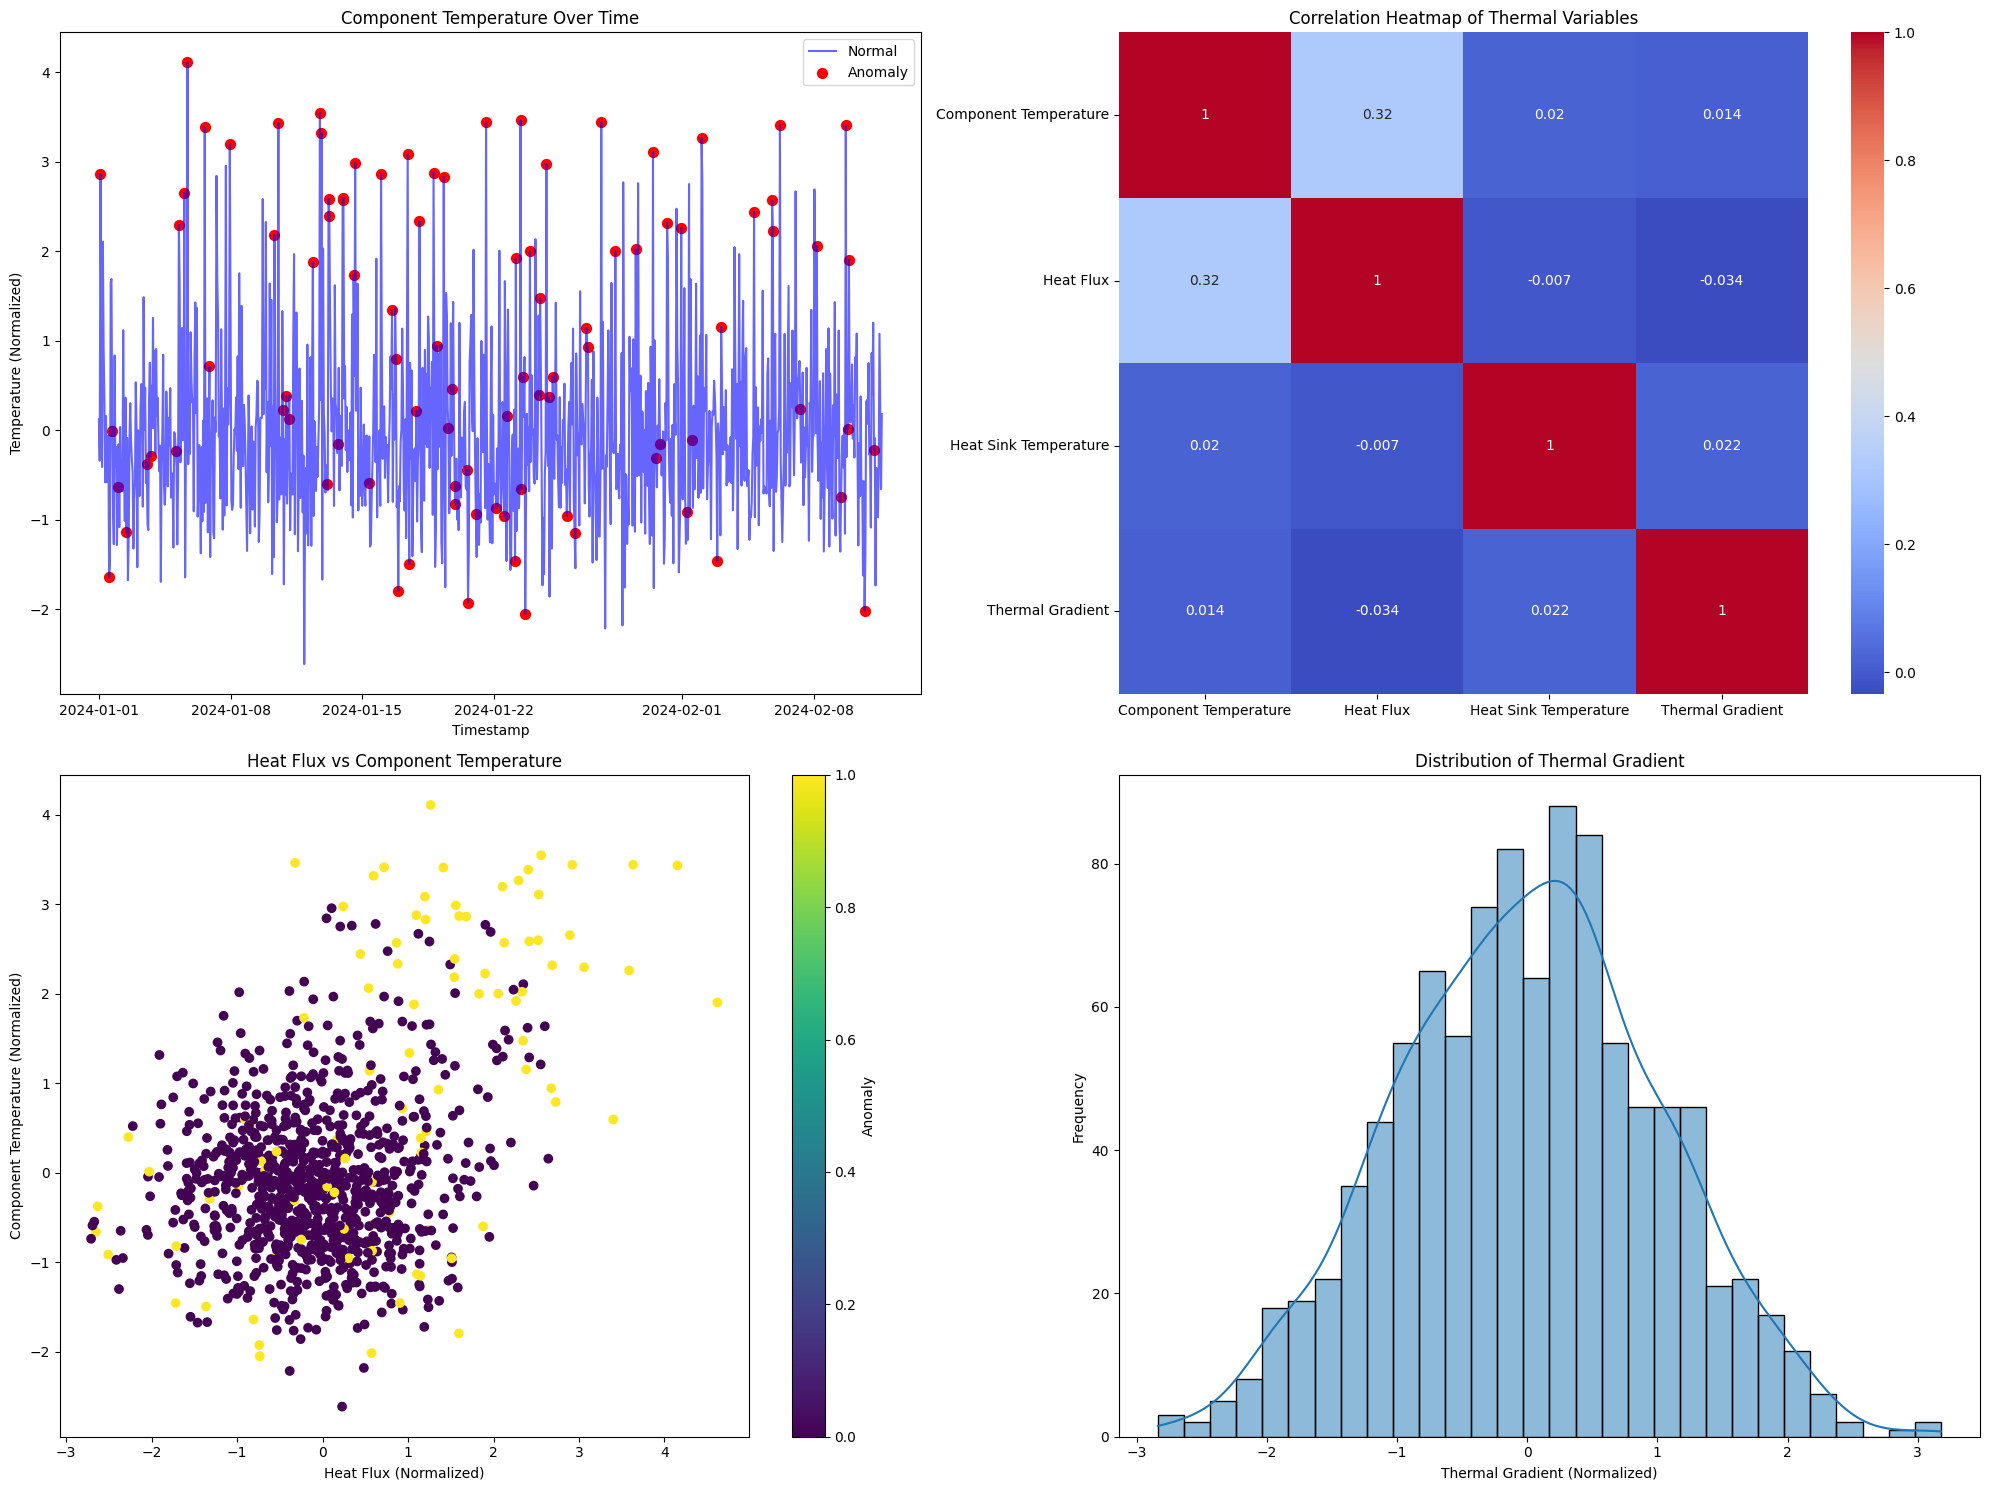


Comparison Table (First 10 rows):
+---------------------+-------------------------+-------------+------------------+---------------------+
| Timestamp           |   Component Temperature |   Heat Flux |   Actual_Anomaly |   Predicted_Anomaly |
+=====================+=========================+=============+==================+=====================+
| 2024-01-01 00:00:00 |                    0.13 |        0.96 |                0 |                   0 |
+---------------------+-------------------------+-------------+------------------+---------------------+
| 2024-01-01 01:00:00 |                   -0.34 |        0.55 |                0 |                   0 |
+---------------------+-------------------------+-------------+------------------+---------------------+
| 2024-01-01 02:00:00 |                    2.86 |        1.68 |                1 |                   1 |
+---------------------+-------------------------+-------------+------------------+---------------------+
| 2024-01-01 03:00:0

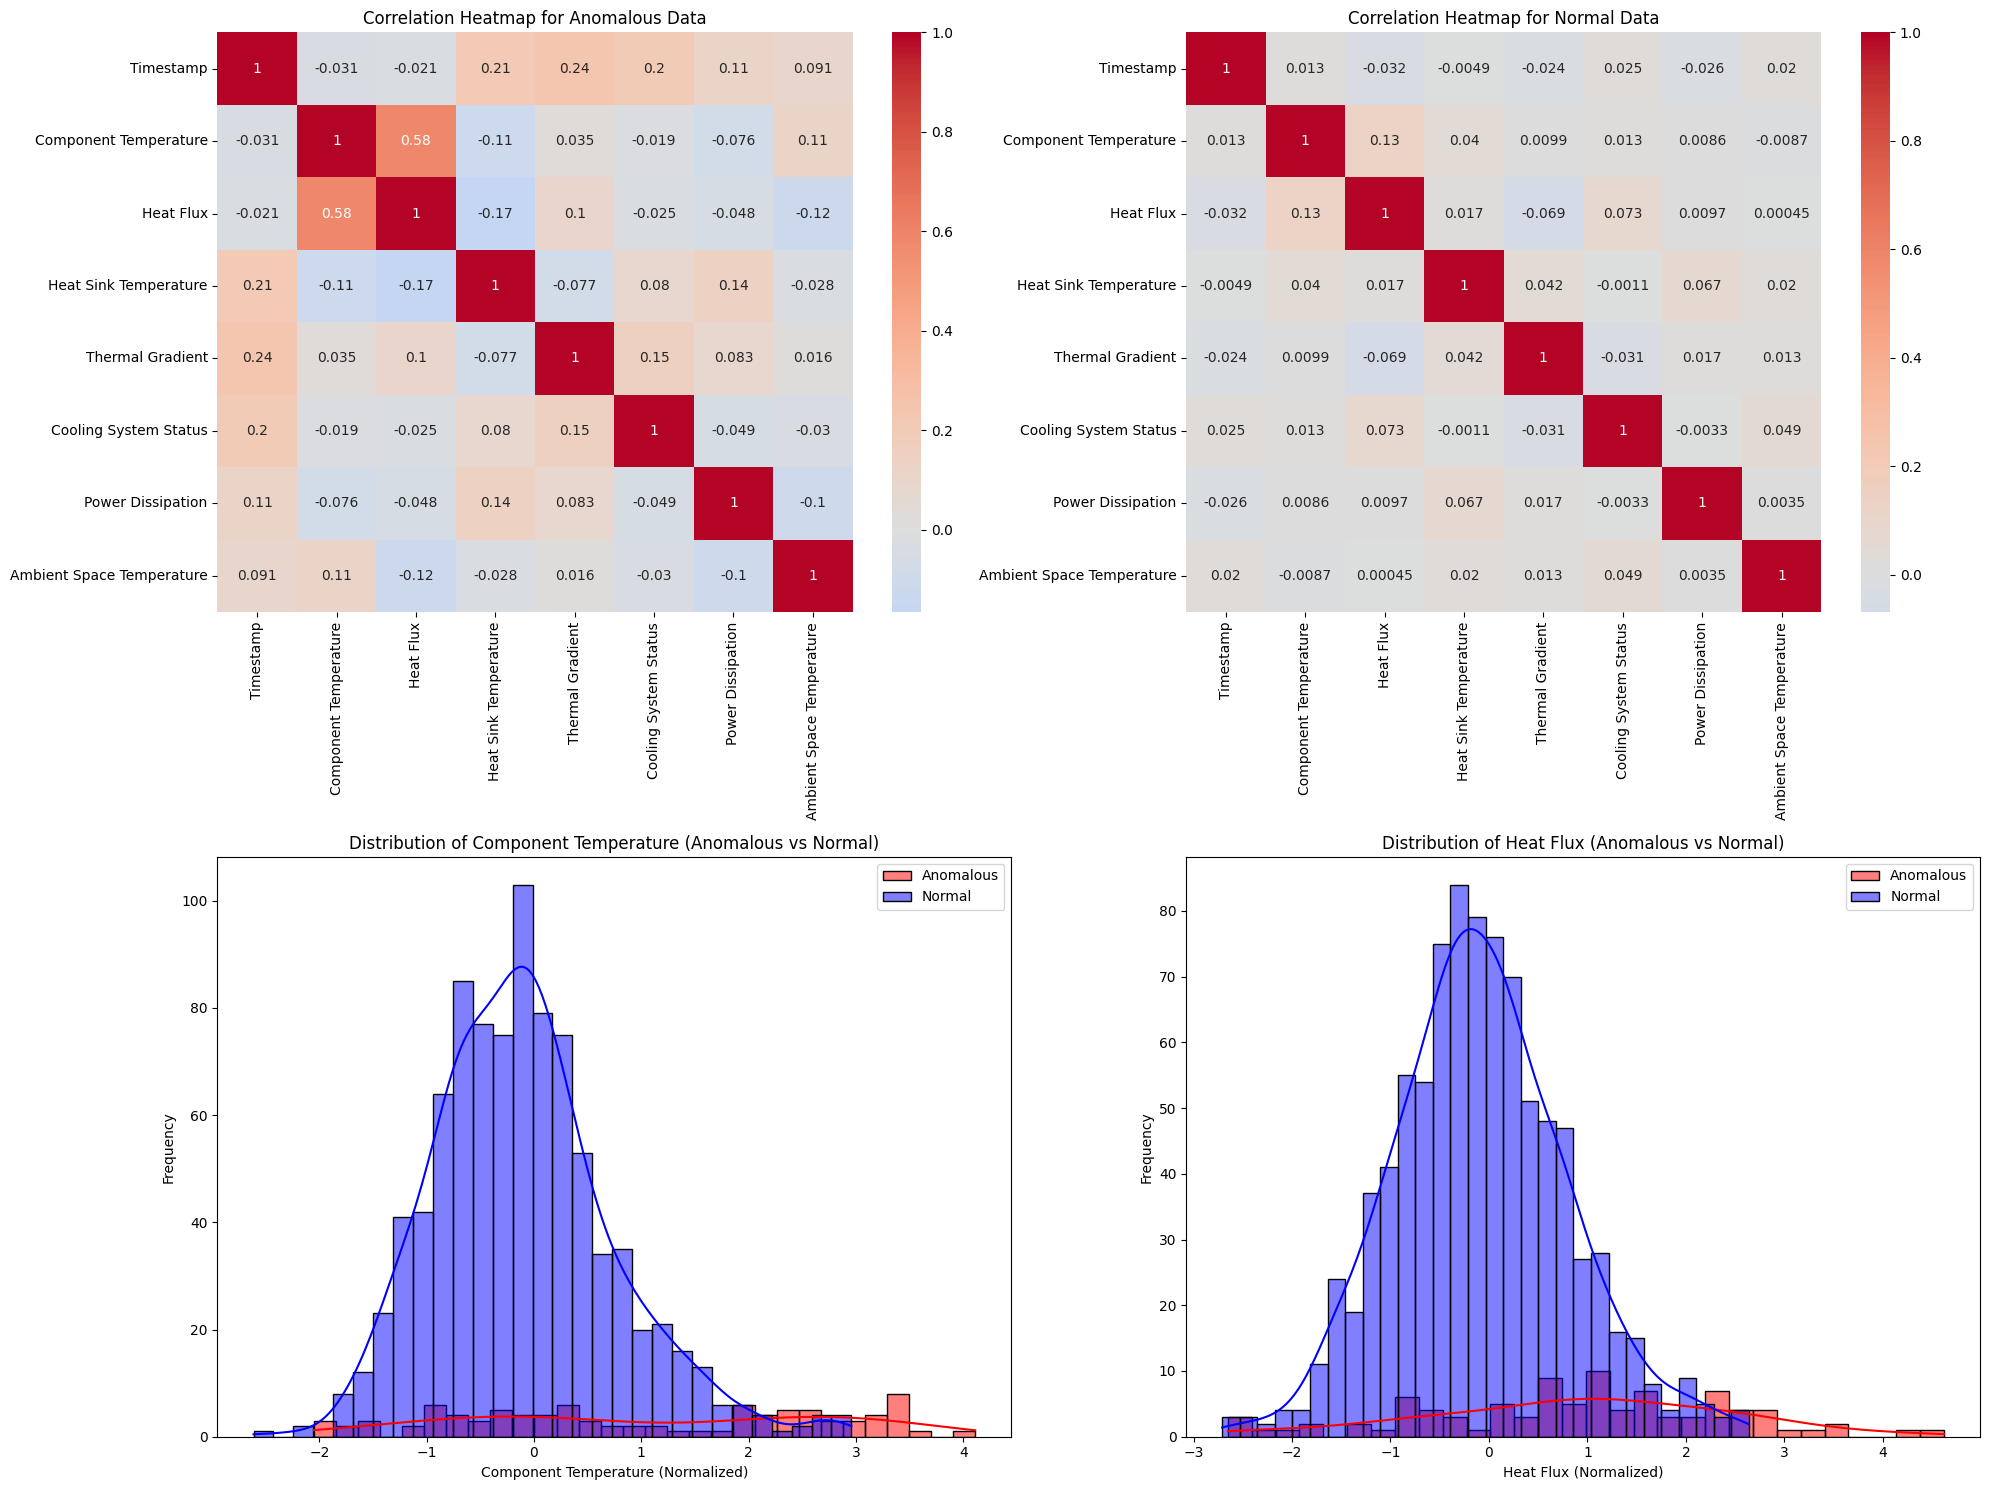

In [ ]:
#Thermal Management
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# 1. Data Generation
def generate_thermal_data(n_samples=1000):
    np.random.seed(42)
    timestamps = pd.date_range(start='2024-01-01', periods=n_samples, freq='H')

    data = {
        'Timestamp': timestamps,
        'Component Temperature': np.random.normal(50, 10, n_samples),
        'Heat Flux': np.random.normal(500, 100, n_samples),
        'Heat Sink Temperature': np.random.normal(30, 5, n_samples),
        'Thermal Gradient': np.random.normal(20, 5, n_samples),
        'Cooling System Status': np.random.choice(['on', 'off'], n_samples),
        'Power Dissipation': np.random.normal(100, 20, n_samples),
        'Ambient Space Temperature': np.random.normal(-270, 10, n_samples)
    }

    # Introduce anomalies
    anomaly_indices = np.random.choice(n_samples, size=int(n_samples * 0.1), replace=False)
    data['Component Temperature'][anomaly_indices] += np.random.normal(30, 5, len(anomaly_indices))
    data['Heat Flux'][anomaly_indices] += np.random.normal(200, 50, len(anomaly_indices))

    return pd.DataFrame(data)

# Generate data
thermal_df = generate_thermal_data()

# 2. Data Preprocessing
# Encoding Cooling System Status
encoder = LabelEncoder()
thermal_df['Cooling System Status'] = encoder.fit_transform(thermal_df['Cooling System Status'])

scaler = StandardScaler()
numeric_columns = thermal_df.select_dtypes(include=[np.number]).columns
thermal_df[numeric_columns] = scaler.fit_transform(thermal_df[numeric_columns])

# 3. Model Development
features = thermal_df.drop(['Timestamp'], axis=1)
X_train, X_test = train_test_split(features, test_size=0.2, random_state=42)

model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X_train)

# 4. Anomaly Detection
anomalies = model.predict(features)
anomalies = pd.Series(anomalies).map({1: 0, -1: 1})

# 5. Visualization
def visualize_thermal_management(df, anomalies):
    plt.figure(figsize=(20, 15))

    # Component Temperature Over Time
    plt.subplot(2, 2, 1)
    plt.plot(df['Timestamp'], df['Component Temperature'], label='Normal', color='blue', alpha=0.6)
    plt.scatter(df['Timestamp'][anomalies == 1], df['Component Temperature'][anomalies == 1],
                color='red', label='Anomaly', s=50)
    plt.title('Component Temperature Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Temperature (Normalized)')
    plt.legend()

    # Correlation Heatmap
    plt.subplot(2, 2, 2)
    corr = df[['Component Temperature', 'Heat Flux', 'Heat Sink Temperature', 'Thermal Gradient']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap of Thermal Variables')

    # Heat Flux vs Component Temperature
    plt.subplot(2, 2, 3)
    scatter = plt.scatter(df['Heat Flux'], df['Component Temperature'], c=anomalies, cmap='viridis')
    plt.title('Heat Flux vs Component Temperature')
    plt.xlabel('Heat Flux (Normalized)')
    plt.ylabel('Component Temperature (Normalized)')
    plt.colorbar(scatter, label='Anomaly')

    # Thermal Gradient Distribution
    plt.subplot(2, 2, 4)
    sns.histplot(df['Thermal Gradient'], kde=True, bins=30)
    plt.title('Distribution of Thermal Gradient')
    plt.xlabel('Thermal Gradient (Normalized)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

visualize_thermal_management(thermal_df, anomalies)

# 6. Comparison Table
def create_comparison_table(df, anomalies):
    comparison_df = df.copy()
    comparison_df['Predicted_Anomaly'] = anomalies
    comparison_df['Actual_Anomaly'] = np.where(
        (comparison_df['Component Temperature'] > 1.5) |
        (comparison_df['Heat Flux'] > 1.5),
        1, 0
    )

    selected_columns = ['Timestamp', 'Component Temperature', 'Heat Flux', 'Actual_Anomaly', 'Predicted_Anomaly']
    table_data = comparison_df[selected_columns].values.tolist()
    headers = selected_columns

    table = tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=".2f")
    print("\nComparison Table (First 10 rows):")
    print(tabulate(table_data[:10], headers=headers, tablefmt="grid", floatfmt=".2f"))

    # Confusion Matrix
    cm = confusion_matrix(comparison_df['Actual_Anomaly'], comparison_df['Predicted_Anomaly'])
    print("\nConfusion Matrix:")
    print(tabulate(cm, headers=['Predicted Normal', 'Predicted Anomaly'], showindex=['Actual Normal', 'Actual Anomaly'], tablefmt="grid"))

    # Classification Report
    cr = classification_report(comparison_df['Actual_Anomaly'], comparison_df['Predicted_Anomaly'])
    print("\nClassification Report:")
    print(cr)

create_comparison_table(thermal_df, anomalies)

# 7. Enhanced Recommendation System
def generate_recommendations(df, anomalies):
    recommendations = []

    # Analyze component temperature
    high_temp_anomalies = df[(df['Component Temperature'] > 1.5) & (anomalies == 1)]
    if not high_temp_anomalies.empty:
        temp_count = len(high_temp_anomalies)
        recommendations.append(f"Critical: Implement enhanced cooling for {temp_count} components experiencing abnormally high temperatures.")

    # Analyze heat flux
    high_flux_anomalies = df[(df['Heat Flux'] > 1.5) & (anomalies == 1)]
    if not high_flux_anomalies.empty:
        flux_count = len(high_flux_anomalies)
        recommendations.append(f"Warning: Investigate and mitigate {flux_count} areas of excessive heat transfer.")

    # Analyze thermal gradient
    high_gradient_anomalies = df[(df['Thermal Gradient'] > 1.5) & (anomalies == 1)]
    if not high_gradient_anomalies.empty:
        gradient_count = len(high_gradient_anomalies)
        recommendations.append(f"Caution: Address {gradient_count} areas with unusually high thermal gradients to prevent stress on components.")

    # Analyze overall system performance
    anomaly_rate = anomalies.sum() / len(anomalies)
    if anomaly_rate > 0.1:
        recommendations.append(f"Alert: High anomaly rate detected ({anomaly_rate:.2%}). Conduct a comprehensive system review.")
    elif 0.05 < anomaly_rate <= 0.1:
        recommendations.append(f"Notice: Moderate anomaly rate detected ({anomaly_rate:.2%}). Schedule a system check-up.")
    else:
        recommendations.append(f"Info: Low anomaly rate ({anomaly_rate:.2%}). Continue regular monitoring and maintenance.")

    # Power management recommendation
    if df['Power Dissipation'].mean() > 0.5:  # Assuming normalized data
        recommendations.append("Optimize power distribution to reduce overall heat generation.")

    # Cooling system recommendation
    if (df['Cooling System Status'] == 0).mean() > 0.2:  # 0 corresponds to 'off'
        recommendations.append("Consider upgrading cooling systems to ensure they are active during critical operations.")

    return recommendations

recommendations = generate_recommendations(thermal_df, anomalies)
print("\nGenerated Recommendations:")
for rec in recommendations:
    print(f"- {rec}")

# 8. Final Analysis and Enhanced Visualization
def final_analysis(df, anomalies):
    anomaly_indices = anomalies[anomalies == 1].index
    normal_indices = anomalies[anomalies == 0].index

    plt.figure(figsize=(20, 15))

    # Heat Map for Anomalies
    plt.subplot(2, 2, 1)
    sns.heatmap(df.iloc[anomaly_indices].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap for Anomalous Data')

    # Heat Map for Normal Data
    plt.subplot(2, 2, 2)
    sns.heatmap(df.iloc[normal_indices].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap for Normal Data')

    # Distribution of Component Temperature (Anomalous vs Normal)
    plt.subplot(2, 2, 3)
    sns.histplot(df.iloc[anomaly_indices]['Component Temperature'], color='red', label='Anomalous', kde=True, bins=30)
    sns.histplot(df.iloc[normal_indices]['Component Temperature'], color='blue', label='Normal', kde=True, bins=30)
    plt.title('Distribution of Component Temperature (Anomalous vs Normal)')
    plt.xlabel('Component Temperature (Normalized)')
    plt.ylabel('Frequency')
    plt.legend()

    # Distribution of Heat Flux (Anomalous vs Normal)
    plt.subplot(2, 2, 4)
    sns.histplot(df.iloc[anomaly_indices]['Heat Flux'], color='red', label='Anomalous', kde=True, bins=30)
    sns.histplot(df.iloc[normal_indices]['Heat Flux'], color='blue', label='Normal', kde=True, bins=30)
    plt.title('Distribution of Heat Flux (Anomalous vs Normal)')
    plt.xlabel('Heat Flux (Normalized)')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

final_analysis(thermal_df, anomalies)


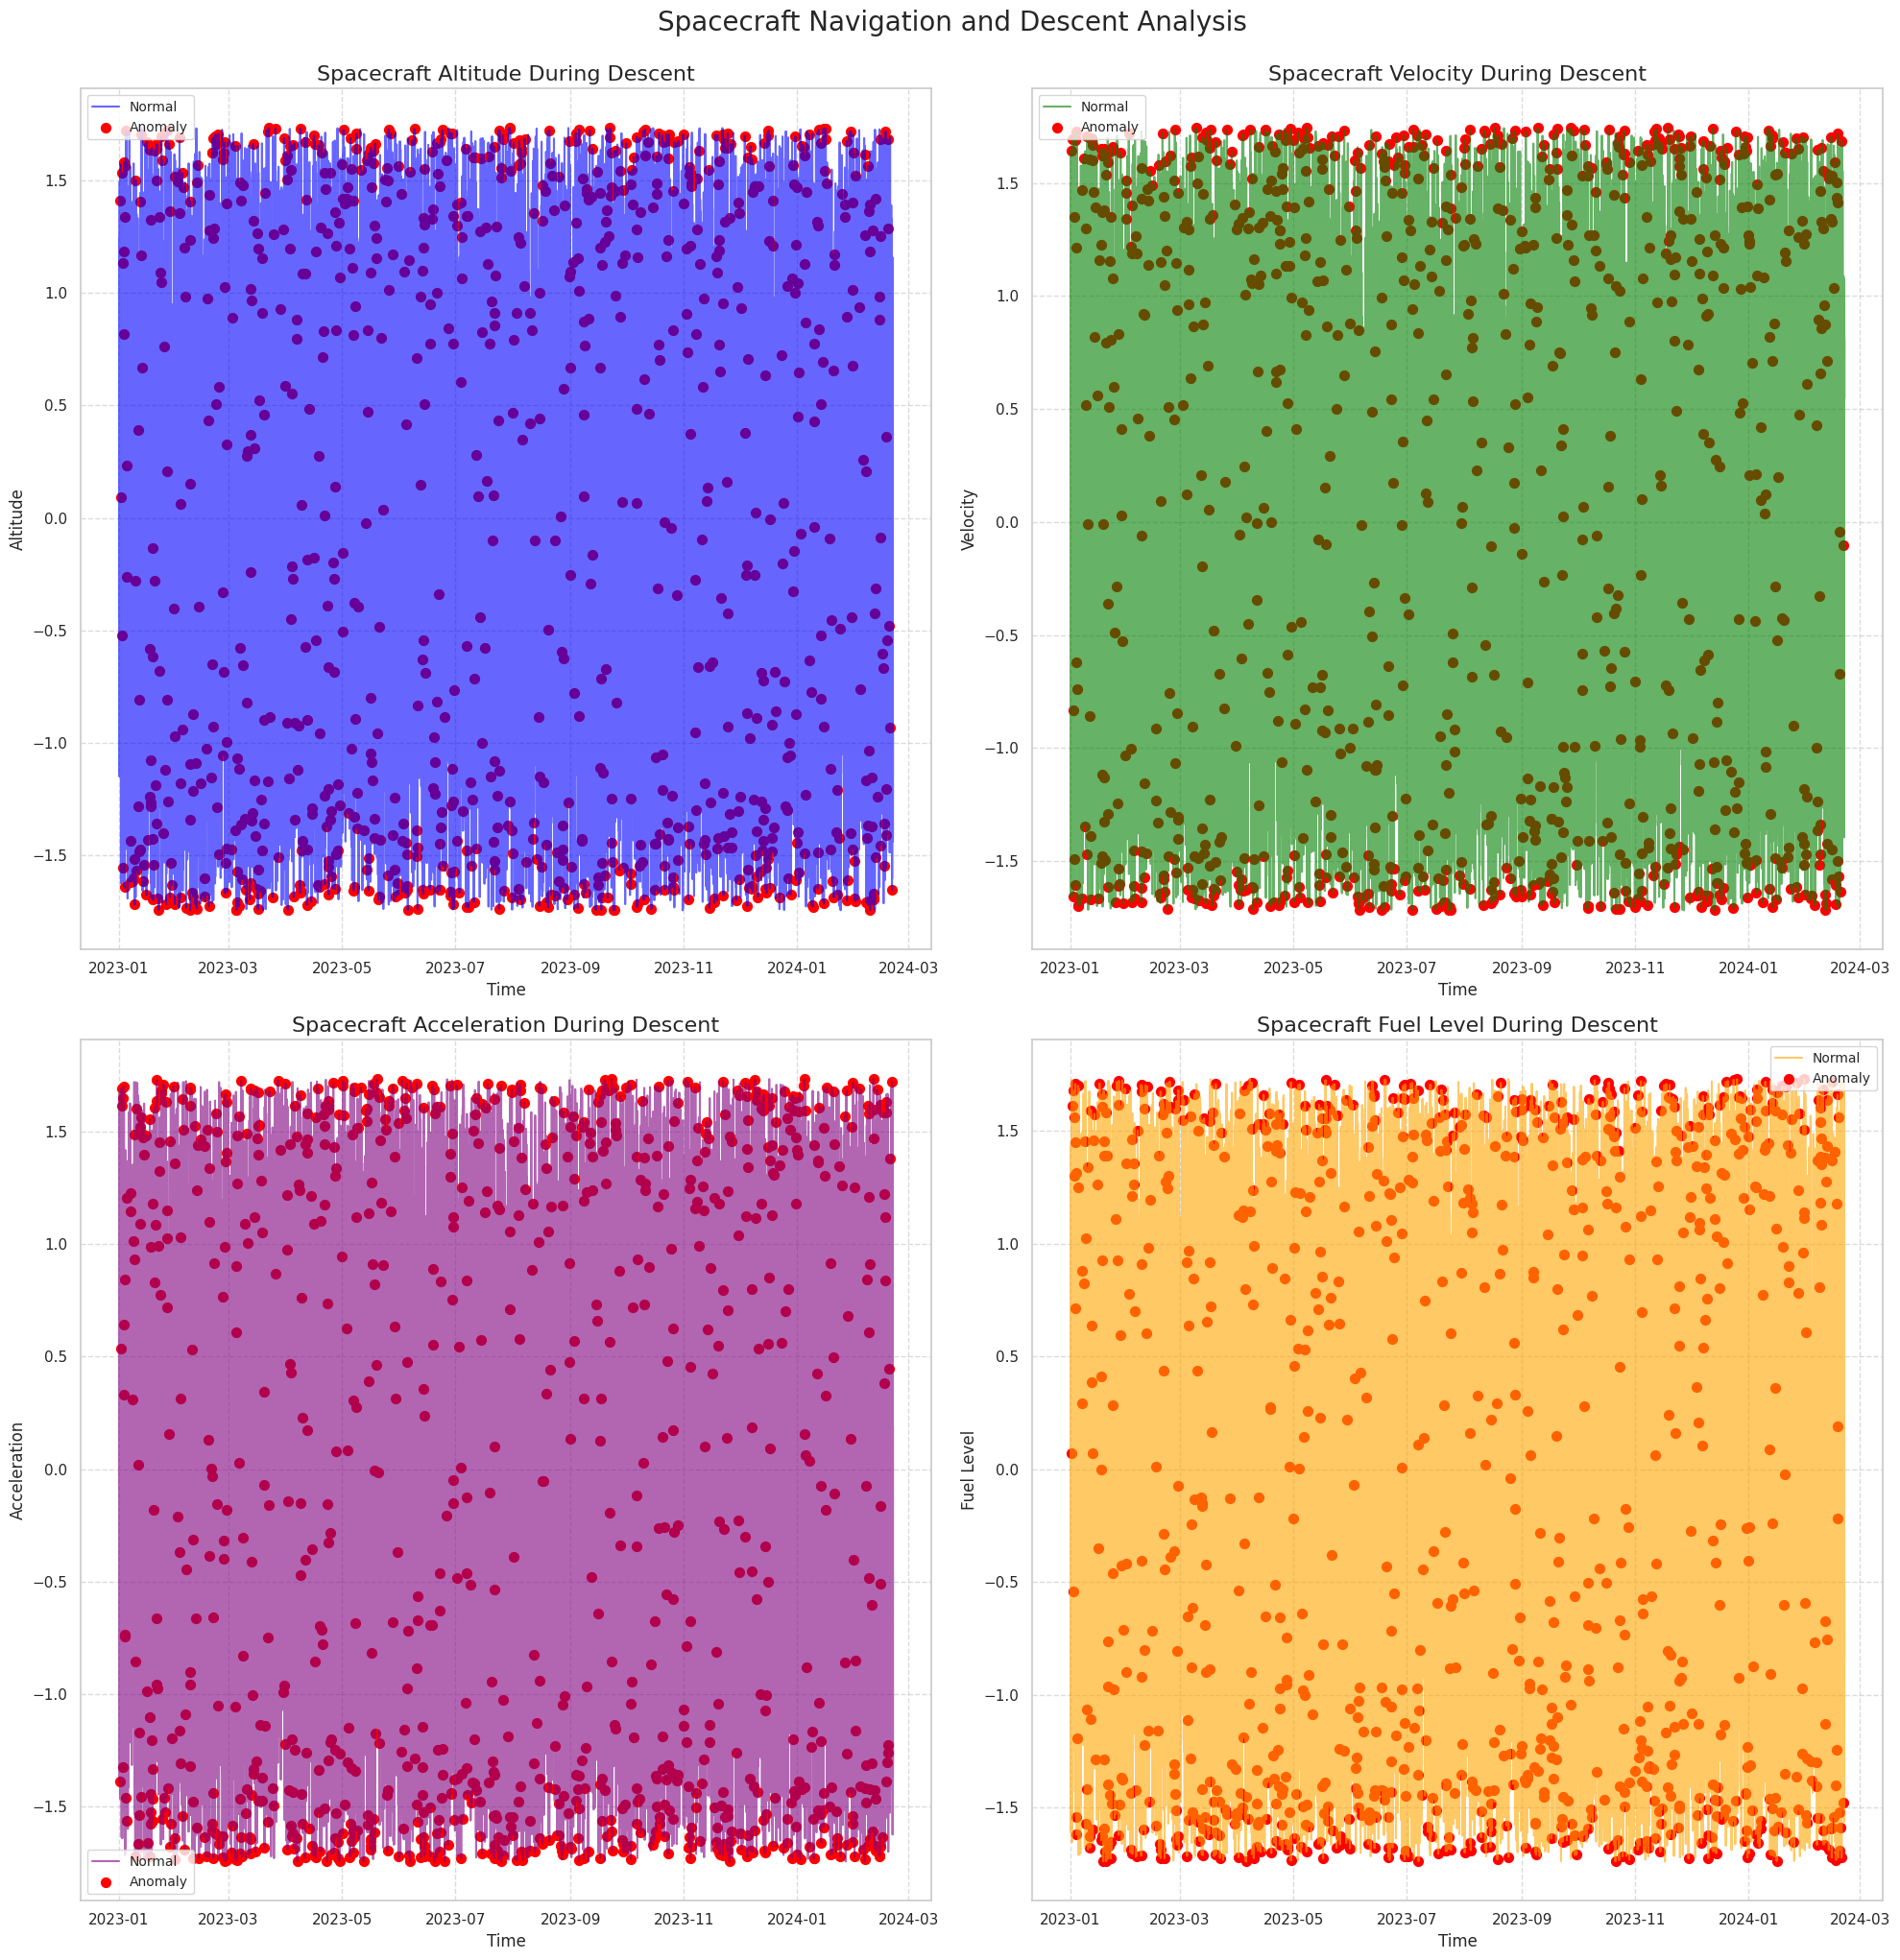

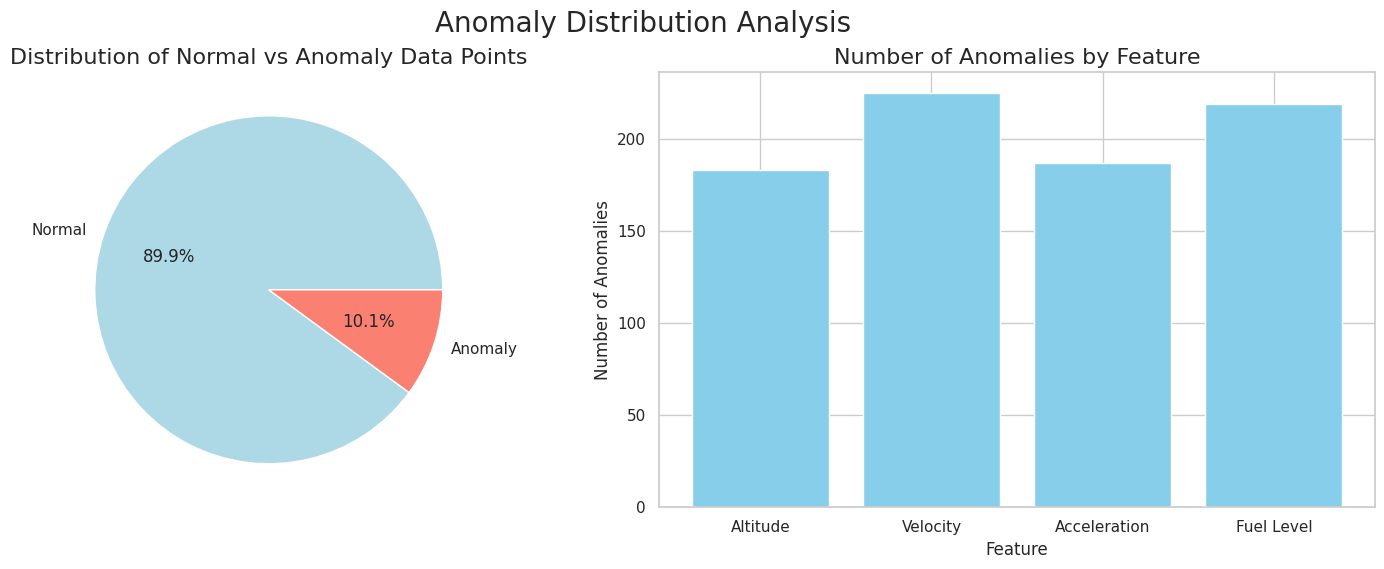


Comparison Table (First 10 rows):
+---------------------+------------+------------+----------------+--------------+------------------+---------------------+
| Timestamp           |   Altitude |   Velocity |   Acceleration |   Fuel Level |   Actual_Anomaly |   Predicted_Anomaly |
+=====================+============+============+================+==============+==================+=====================+
| 2023-01-01 00:00:00 |      -0.45 |       1.50 |          -0.07 |        -1.61 |                1 |                   0 |
+---------------------+------------+------------+----------------+--------------+------------------+---------------------+
| 2023-01-01 01:00:00 |       1.25 |      -1.35 |           1.05 |        -0.49 |                0 |                   0 |
+---------------------+------------+------------+----------------+--------------+------------------+---------------------+
| 2023-01-01 02:00:00 |      -0.67 |      -0.66 |           0.74 |         1.43 |                0 |    

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# (Previous functions remain the same)

# 4. Improved Visualization
def visualize_navigation_descent(df, anomalies):
    plt.figure(figsize=(20, 20))

    # Altitude Over Time
    plt.subplot(2, 2, 1)
    plt.plot(df['Timestamp'], df['Altitude'], label='Normal', color='blue', alpha=0.6)
    plt.scatter(df['Timestamp'][anomalies == 1], df['Altitude'][anomalies == 1], color='red', label='Anomaly', s=50)
    plt.title('Spacecraft Altitude During Descent', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Altitude', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Velocity Over Time
    plt.subplot(2, 2, 2)
    plt.plot(df['Timestamp'], df['Velocity'], label='Normal', color='green', alpha=0.6)
    plt.scatter(df['Timestamp'][anomalies == 1], df['Velocity'][anomalies == 1], color='red', label='Anomaly', s=50)
    plt.title('Spacecraft Velocity During Descent', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Velocity', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Acceleration Over Time
    plt.subplot(2, 2, 3)
    plt.plot(df['Timestamp'], df['Acceleration'], label='Normal', color='purple', alpha=0.6)
    plt.scatter(df['Timestamp'][anomalies == 1], df['Acceleration'][anomalies == 1], color='red', label='Anomaly', s=50)
    plt.title('Spacecraft Acceleration During Descent', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Acceleration', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Fuel Level Over Time
    plt.subplot(2, 2, 4)
    plt.plot(df['Timestamp'], df['Fuel Level'], label='Normal', color='orange', alpha=0.6)
    plt.scatter(df['Timestamp'][anomalies == 1], df['Fuel Level'][anomalies == 1], color='red', label='Anomaly', s=50)
    plt.title('Spacecraft Fuel Level During Descent', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Fuel Level', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.suptitle('Spacecraft Navigation and Descent Analysis', fontsize=20, y=1.02)
    plt.show()

# Additional visualization function for anomaly distribution
def visualize_anomaly_distribution(df, anomalies):
    plt.figure(figsize=(15, 10))

    # Pie chart of anomalies
    plt.subplot(2, 2, 1)
    anomaly_counts = anomalies.value_counts()
    plt.pie(anomaly_counts, labels=['Normal', 'Anomaly'], autopct='%1.1f%%', colors=['lightblue', 'salmon'])
    plt.title('Distribution of Normal vs Anomaly Data Points', fontsize=16)

    # Bar plot of anomalies by feature
    plt.subplot(2, 2, 2)
    feature_anomalies = {
        'Altitude': ((df['Altitude'] > 1.5) & (anomalies == 1)).sum(),
        'Velocity': ((df['Velocity'] > 1.5) & (anomalies == 1)).sum(),
        'Acceleration': ((df['Acceleration'] > 1.5) & (anomalies == 1)).sum(),
        'Fuel Level': ((df['Fuel Level'] < -1.5) & (anomalies == 1)).sum()
    }
    plt.bar(feature_anomalies.keys(), feature_anomalies.values(), color='skyblue')
    plt.title('Number of Anomalies by Feature', fontsize=16)
    plt.xlabel('Feature', fontsize=12)
    plt.ylabel('Number of Anomalies', fontsize=12)

    plt.tight_layout()
    plt.suptitle('Anomaly Distribution Analysis', fontsize=20, y=1.02)
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load data
    file_path = '/content/navigation_and_descent_data_large.csv'
    navigation_df = load_and_preprocess_data(file_path)

    # Model Development
    model = develop_model(navigation_df)

    # Anomaly Detection
    navigation_anomalies = detect_anomalies(model, navigation_df)

    # Improved Visualizations
    visualize_navigation_descent(navigation_df, navigation_anomalies)
    visualize_anomaly_distribution(navigation_df, navigation_anomalies)

    # Comparison Table
    create_comparison_table(navigation_df, navigation_anomalies)

    # Recommendations
    recommendations = generate_recommendations(navigation_df, navigation_anomalies)
    print("\nRecommendations based on Anomaly Detection:")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")

    # Conclusion
    conclusion = determine_landing_success(navigation_df, navigation_anomalies)
    print("\nConclusion based on Prediction:")
    print(conclusion)

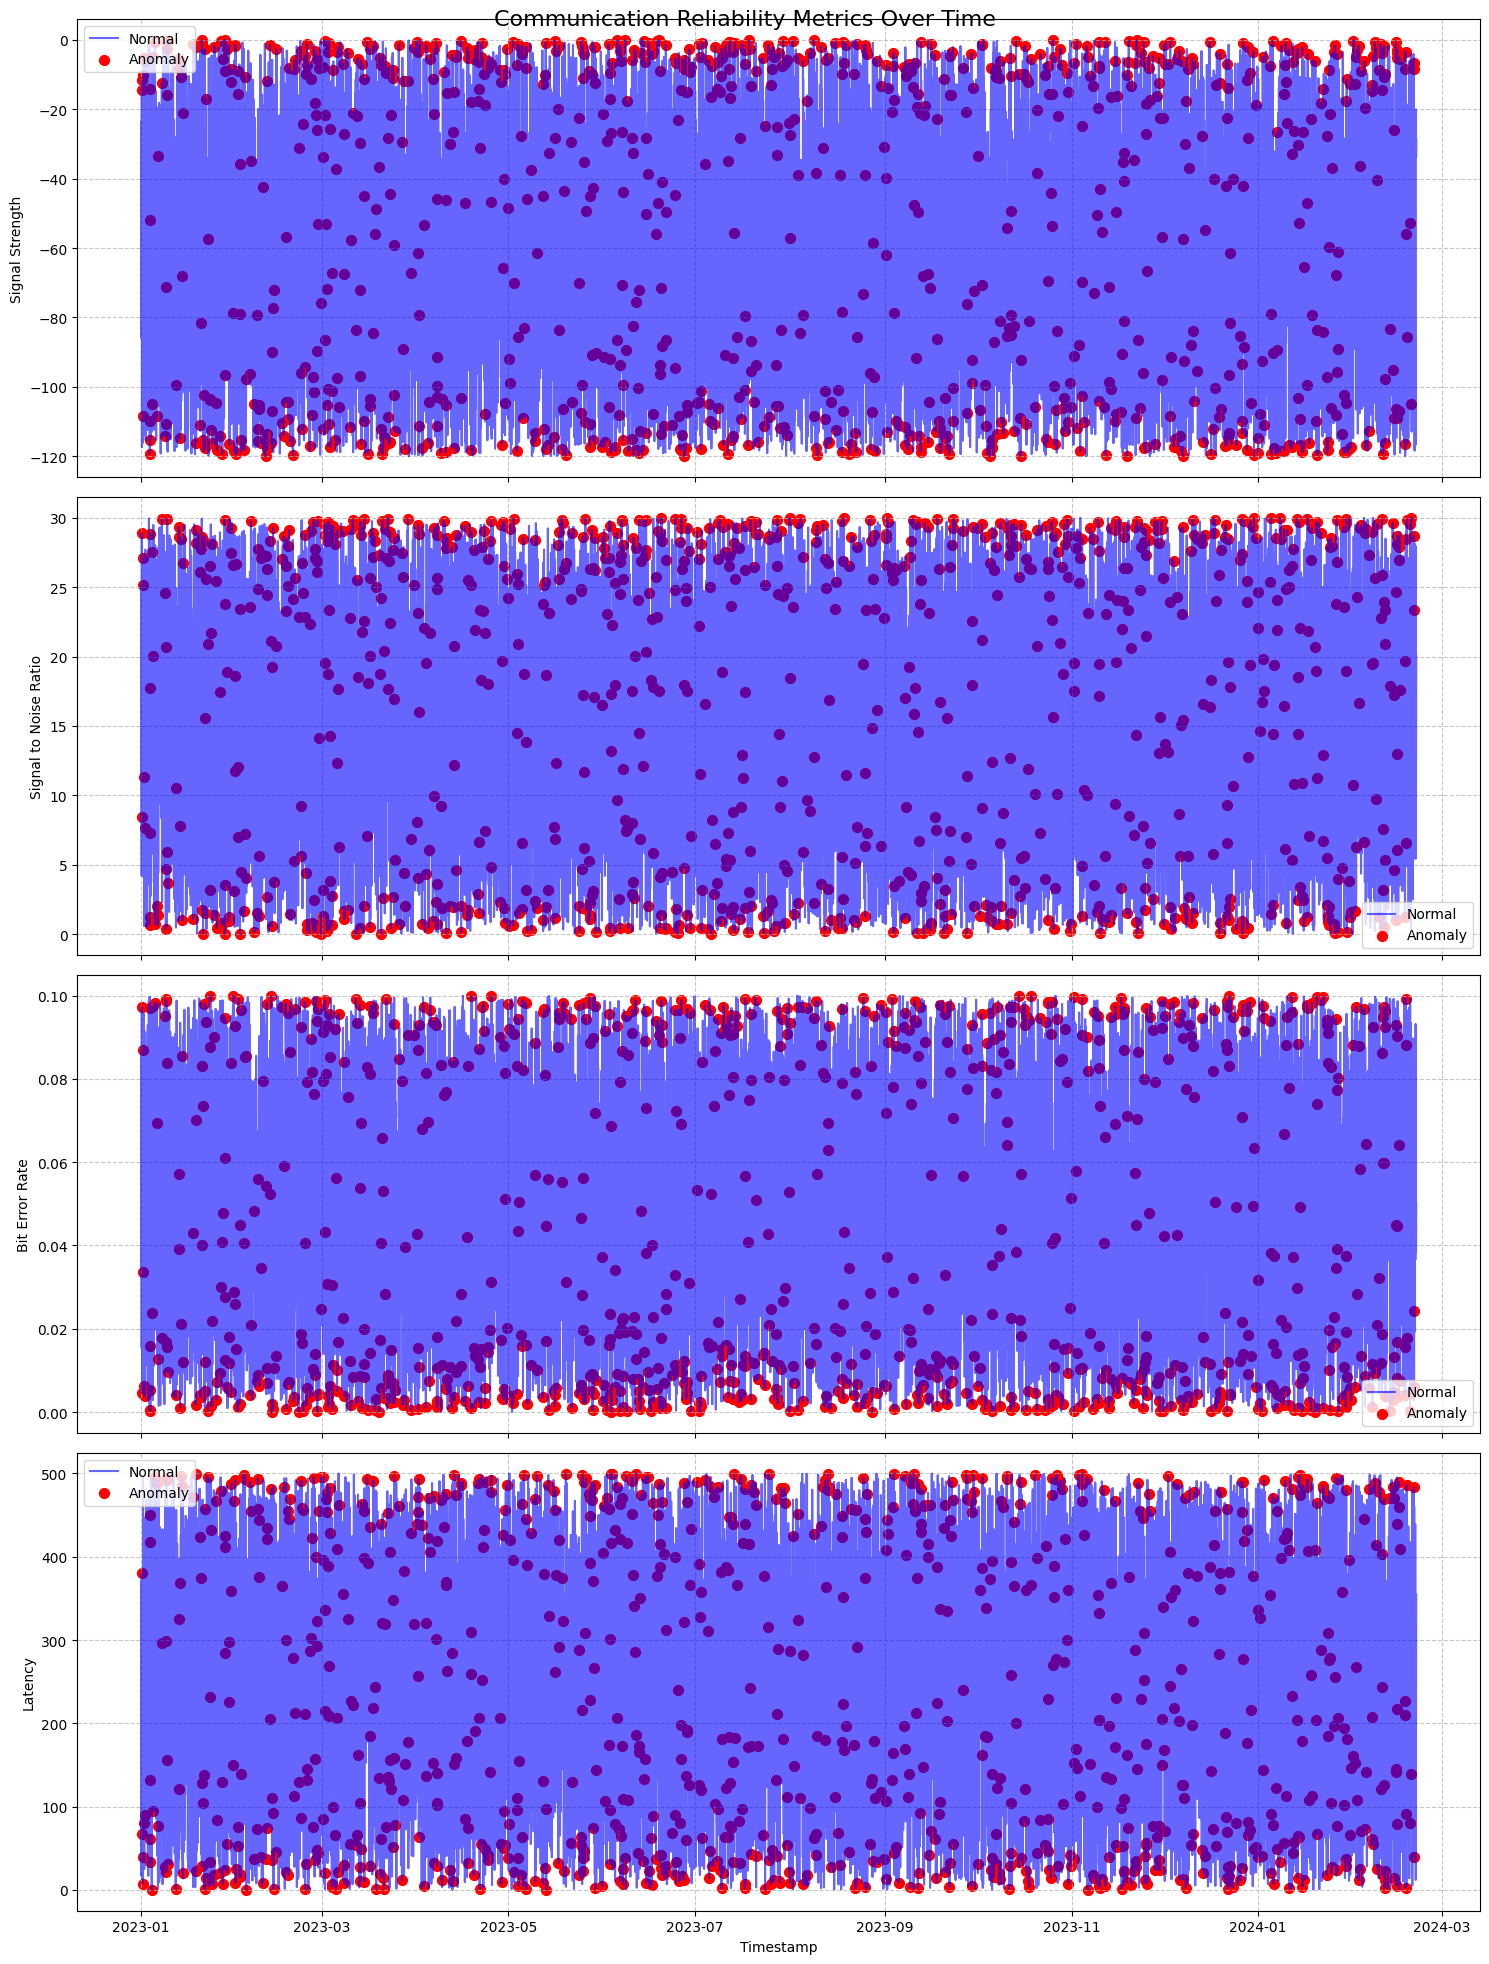

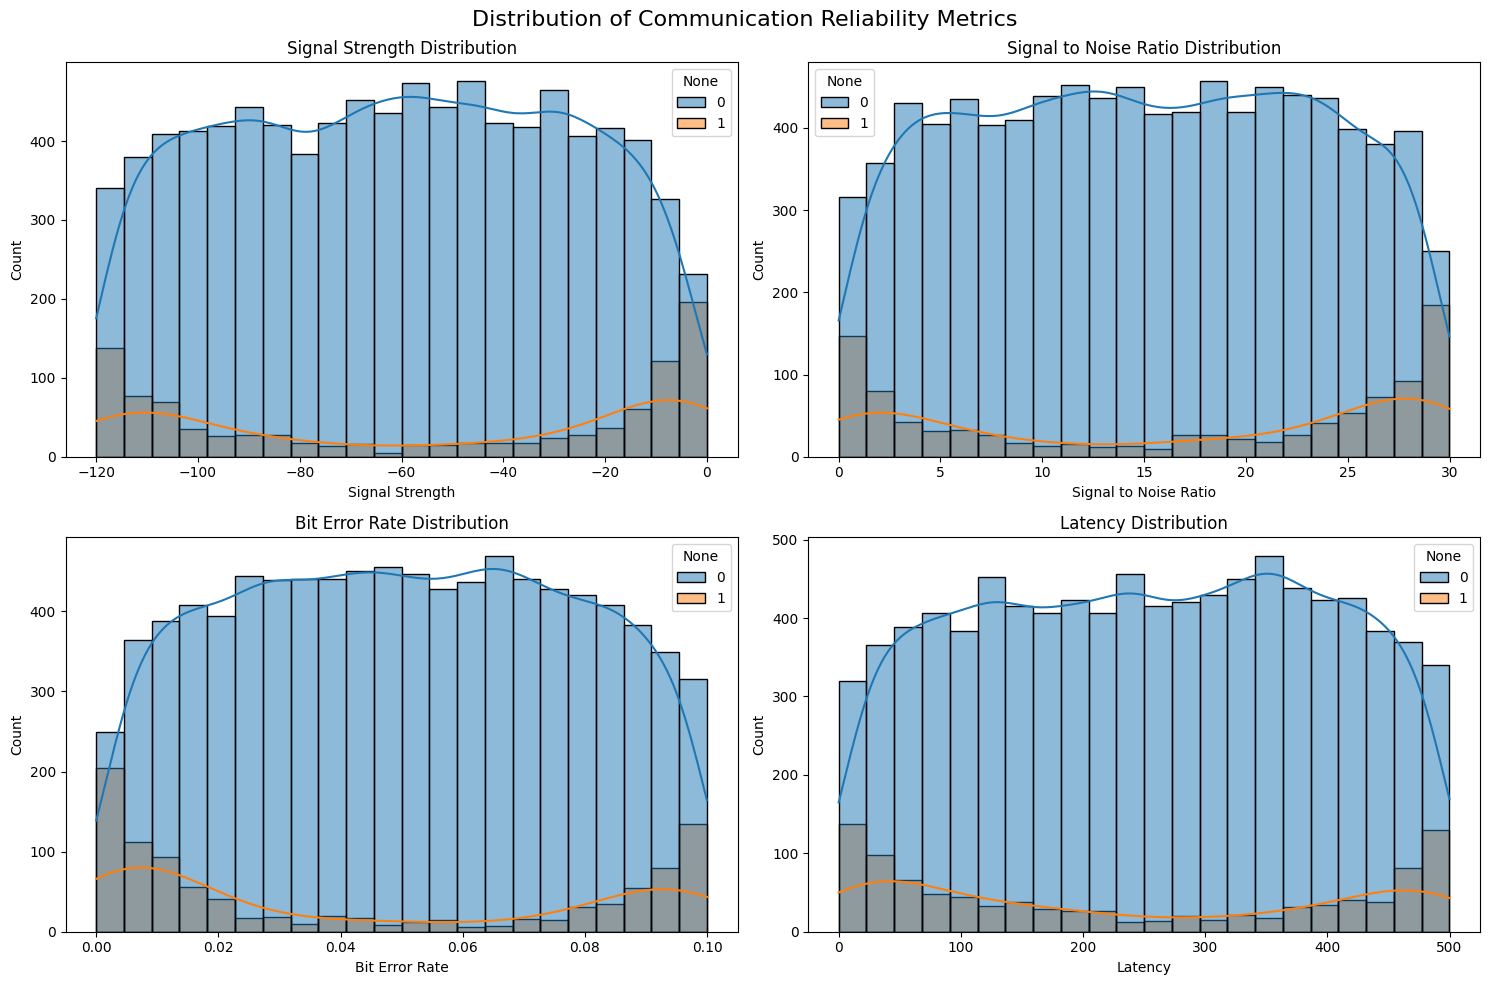

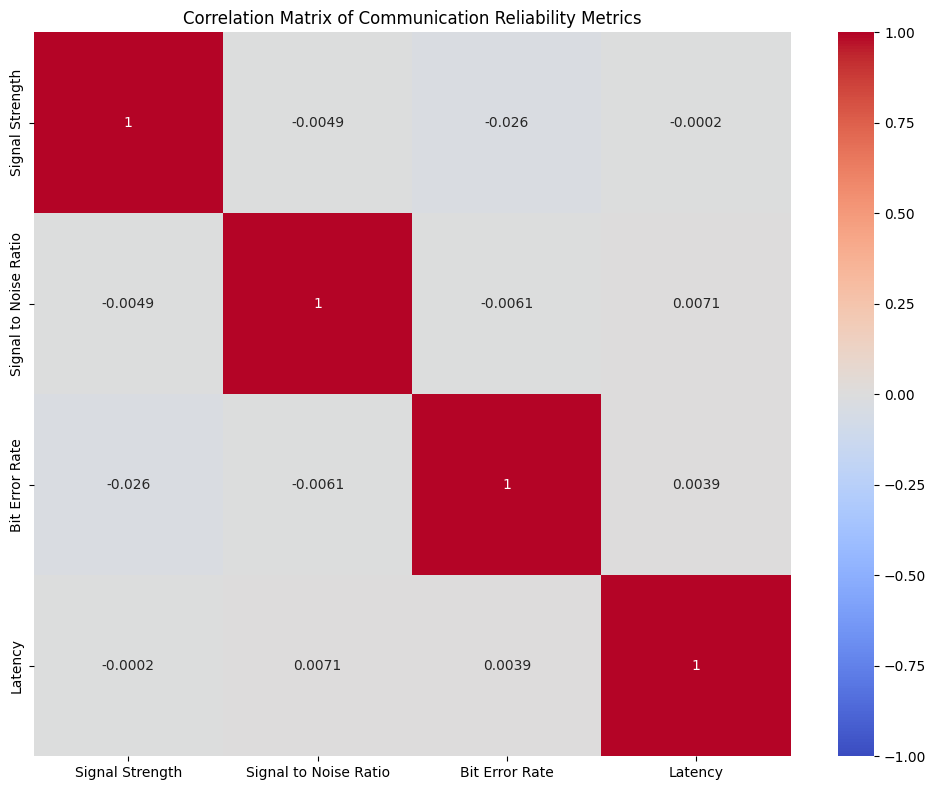


Key Insights:
- Overall anomaly rate: 10.00%
- Average Signal Strength: -60.25
- Average Signal Strength during anomalies: -54.91
- Average Signal to Noise Ratio: 15.08
- Average Signal to Noise Ratio during anomalies: 16.49
- Average Bit Error Rate: 0.05
- Average Bit Error Rate during anomalies: 0.04
- Average Latency: 250.45
- Average Latency during anomalies: 232.78


In [ ]:
#Communication Reliability:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    categorical_columns = ['Link Status', 'Modulation Type']
    for col in categorical_columns:
        if col in df.columns:
            df[col] = pd.Categorical(df[col]).codes

    return df

def detect_anomalies(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    features = [col for col in numeric_columns if col != 'Timestamp']
    X = df[features]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = IsolationForest(contamination=0.1, random_state=42)
    anomalies = model.fit_predict(X_scaled)

    return pd.Series(anomalies).map({1: 0, -1: 1})  # 0 for normal, 1 for anomaly

def visualize_time_series(df, anomalies):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    features = [col for col in numeric_columns if col not in ['Timestamp', 'Modulation Type', 'Link Status']]

    fig, axes = plt.subplots(len(features), 1, figsize=(15, 5*len(features)), sharex=True)
    fig.suptitle('Communication Reliability Metrics Over Time', fontsize=16)

    for i, feature in enumerate(features):
        ax = axes[i] if len(features) > 1 else axes
        ax.plot(df['Timestamp'], df[feature], label='Normal', color='blue', alpha=0.6)
        ax.scatter(df['Timestamp'][anomalies == 1], df[feature][anomalies == 1],
                   color='red', label='Anomaly', s=50)
        ax.set_ylabel(feature)
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)

    plt.xlabel('Timestamp')
    plt.tight_layout()
    plt.show()

def visualize_feature_distributions(df, anomalies):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    features = [col for col in numeric_columns if col not in ['Timestamp', 'Modulation Type', 'Link Status']]

    n_cols = 2
    n_rows = (len(features) + 1) // 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.suptitle('Distribution of Communication Reliability Metrics', fontsize=16)

    for i, feature in enumerate(features):
        ax = axes[i//n_cols, i%n_cols] if n_rows > 1 else axes[i]
        sns.histplot(data=df, x=feature, hue=anomalies, kde=True, ax=ax)
        ax.set_title(f'{feature} Distribution')

    # Remove any unused subplots
    for j in range(i+1, n_rows*n_cols):
        fig.delaxes(axes[j//n_cols, j%n_cols] if n_rows > 1 else axes[j])

    plt.tight_layout()
    plt.show()

def visualize_correlation_matrix(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    features = [col for col in numeric_columns if col not in ['Timestamp', 'Modulation Type', 'Link Status']]

    corr_matrix = df[features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Matrix of Communication Reliability Metrics')
    plt.tight_layout()
    plt.show()

def analyze_categorical_features(df, anomalies):
    categorical_columns = ['Modulation Type', 'Link Status']
    for col in categorical_columns:
        if col in df.columns:
            category_anomalies = df.groupby(col)[col].count()
            category_anomaly_rates = df[anomalies == 1].groupby(col)[col].count() / category_anomalies

            plt.figure(figsize=(10, 6))
            category_anomaly_rates.plot(kind='bar')
            plt.title(f'Anomaly Rates by {col}')
            plt.xlabel(col)
            plt.ylabel('Anomaly Rate')
            plt.tight_layout()
            plt.show()

def generate_insights(df, anomalies):
    insights = []

    # Overall anomaly rate
    anomaly_rate = anomalies.mean()
    insights.append(f"Overall anomaly rate: {anomaly_rate:.2%}")

    numeric_columns = df.select_dtypes(include=[np.number]).columns
    features = [col for col in numeric_columns if col not in ['Timestamp', 'Modulation Type', 'Link Status']]

    for feature in features:
        avg_value = df[feature].mean()
        avg_anomaly_value = df[anomalies == 1][feature].mean()
        insights.append(f"Average {feature}: {avg_value:.2f}")
        insights.append(f"Average {feature} during anomalies: {avg_anomaly_value:.2f}")

    return insights

def main():
    file_path = '/content/communication_reliability_data_large.csv'
    df = load_and_preprocess_data(file_path)
    anomalies = detect_anomalies(df)

    visualize_time_series(df, anomalies)
    visualize_feature_distributions(df, anomalies)
    visualize_correlation_matrix(df)
    analyze_categorical_features(df, anomalies)

    insights = generate_insights(df, anomalies)
    print("\nKey Insights:")
    for insight in insights:
        print(f"- {insight}")

if __name__ == "__main__":
    main()

Column names in dataset: Index(['Timestamp', 'Radiation Level', 'Solar Flare Activity',
       'Shielding Status', 'Mission Duration'],
      dtype='object')


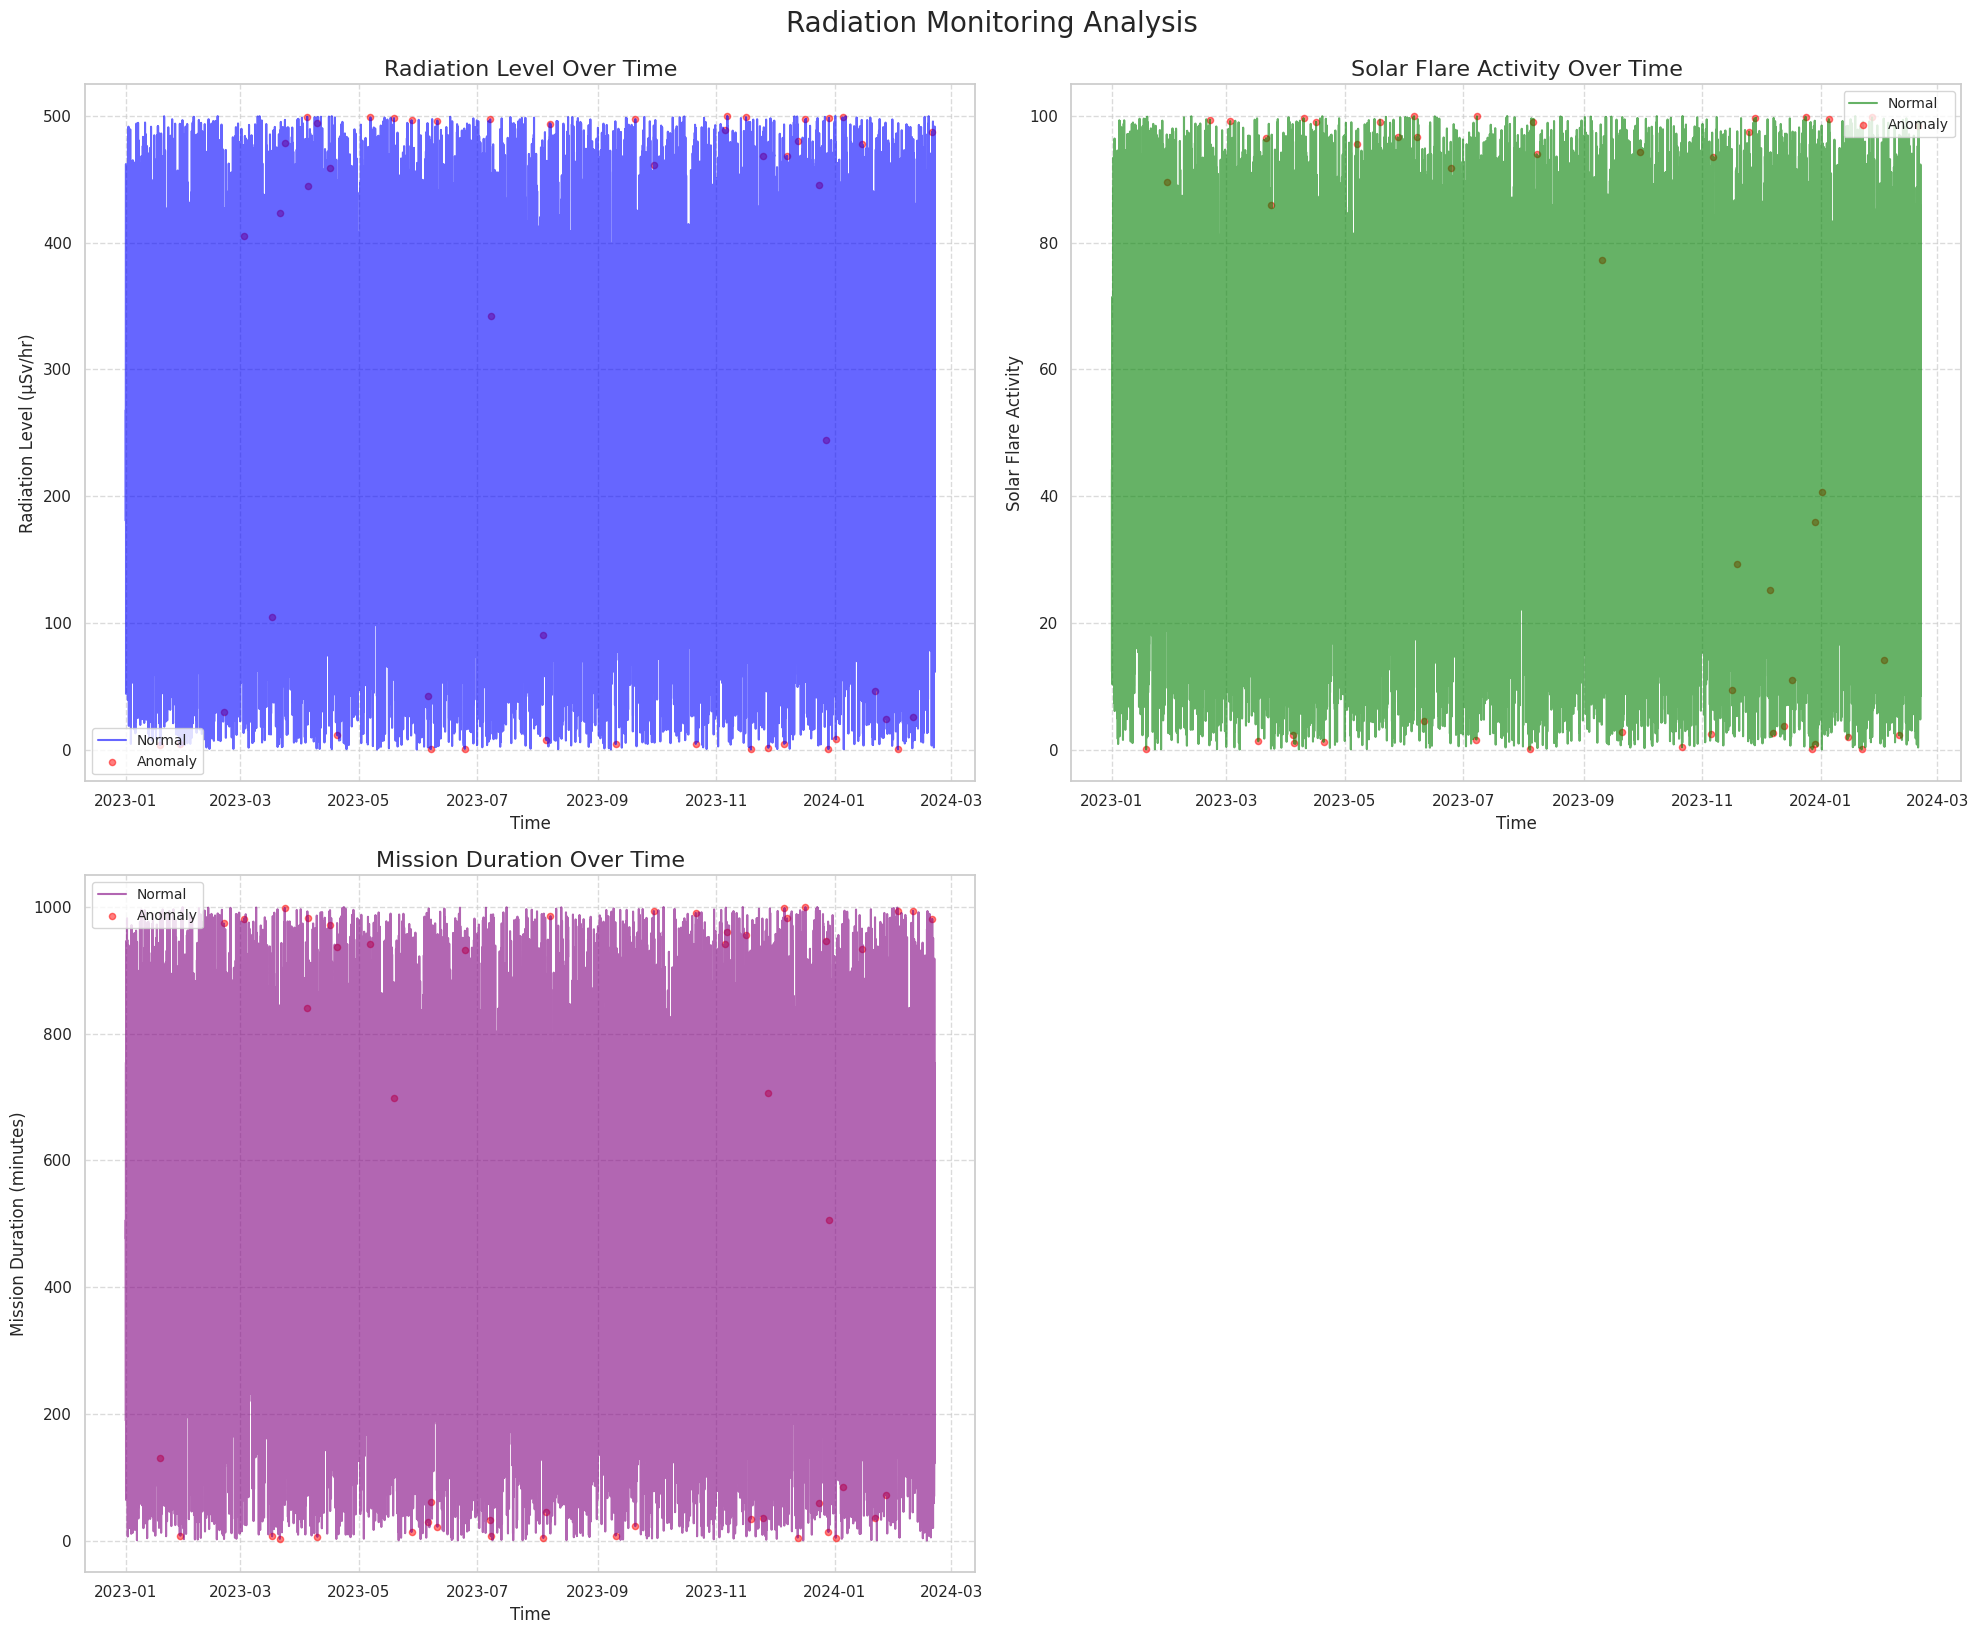

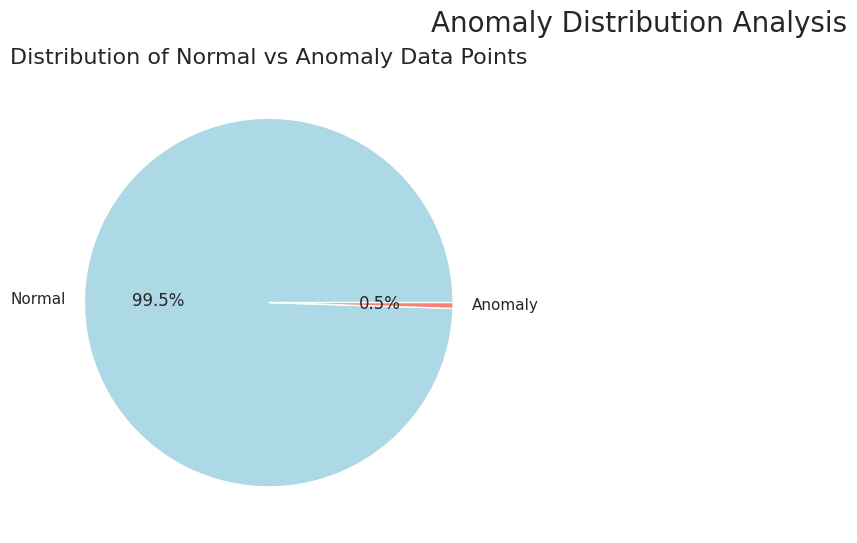

+----------------------+-------------------------------+-------------------+------------------------+--------------------+--------------------+-----------+
|                      | Timestamp                     |   Radiation Level |   Solar Flare Activity |   Shielding Status |   Mission Duration |   Anomaly |
|----------------------+-------------------------------+-------------------+------------------------+--------------------+--------------------+-----------|
| ('Normal', 'count')  | 9950                          |      9950         |          9950          |        9950        |       9950         |      9950 |
| ('Normal', 'mean')   | 2023-07-28 03:54:30.391959808 |       250.508     |            49.7036     |           0.504623 |        496.012     |         0 |
| ('Normal', 'min')    | 2023-01-01 00:00:00           |         0.0959101 |             0.00673826 |           0        |          0.0324129 |         0 |
| ('Normal', '25%')    | 2023-04-15 01:15:00           |       1

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Load and preprocess data
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    print("Column names in dataset:", df.columns)  # Print column names for verification
    df.ffill(inplace=True)  # Forward fill missing values
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # Convert to datetime
    return df

# Develop model with updated features
def develop_model(df):
    # Update features based on the available columns
    features = ['Radiation Level', 'Solar Flare Activity', 'Mission Duration']
    X = df[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Adjust the contamination parameter to reduce the number of detected anomalies
    model = IsolationForest(n_estimators=200, max_samples=0.8, contamination=0.005, random_state=42)
    model.fit(X_scaled)
    return model

# Detect anomalies
def detect_anomalies(model, df):
    features = ['Radiation Level', 'Solar Flare Activity', 'Mission Duration']
    X = df[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    anomalies = model.predict(X_scaled)
    # Convert -1 to 1 for anomalies and 1 to 0 for normal data
    return np.where(anomalies == -1, 1, 0)

# Create comparison table
def create_comparison_table(df, anomalies):
    df['Anomaly'] = anomalies
    normal_data = df[df['Anomaly'] == 0]
    anomaly_data = df[df['Anomaly'] == 1]

    comparison_table = pd.concat([normal_data.describe(), anomaly_data.describe()], keys=['Normal', 'Anomaly'])
    print(tabulate(comparison_table, headers='keys', tablefmt='psql'))

# Generate recommendations
def generate_recommendations(df, anomalies):
    recommendations = []
    if np.any(anomalies == 1):
        recommendations.append("Investigate the periods with detected anomalies.")
        recommendations.append("Check the radiation sensor's status and other relevant parameters.")
        recommendations.append("Consider further analysis on radiation level patterns and solar flare activity.")
    else:
        recommendations.append("No anomalies detected. Continue monitoring.")
    return recommendations

# Determine monitoring success
def determine_monitoring_success(df, anomalies):
    if np.any(anomalies == 1):
        return "Anomalies detected during monitoring. Further investigation required."
    else:
        return "Monitoring appears normal. No significant anomalies detected."

# Improved Visualization
def visualize_radiation_monitoring(df, anomalies):
    sns.set(style="whitegrid")
    plt.figure(figsize=(20, 16))

    # Radiation Level Over Time
    plt.subplot(2, 2, 1)
    plt.plot(df['Timestamp'], df['Radiation Level'], label='Normal', color='blue', alpha=0.6)
    plt.scatter(df['Timestamp'][anomalies == 1], df['Radiation Level'][anomalies == 1], color='red', label='Anomaly', s=20, alpha=0.5)
    plt.title('Radiation Level Over Time', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Radiation Level (µSv/hr)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Solar Flare Activity Over Time
    plt.subplot(2, 2, 2)
    plt.plot(df['Timestamp'], df['Solar Flare Activity'], label='Normal', color='green', alpha=0.6)
    plt.scatter(df['Timestamp'][anomalies == 1], df['Solar Flare Activity'][anomalies == 1], color='red', label='Anomaly', s=20, alpha=0.5)
    plt.title('Solar Flare Activity Over Time', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Solar Flare Activity', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Mission Duration Over Time
    plt.subplot(2, 2, 3)
    plt.plot(df['Timestamp'], df['Mission Duration'], label='Normal', color='purple', alpha=0.6)
    plt.scatter(df['Timestamp'][anomalies == 1], df['Mission Duration'][anomalies == 1], color='red', label='Anomaly', s=20, alpha=0.5)
    plt.title('Mission Duration Over Time', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Mission Duration (minutes)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.suptitle('Radiation Monitoring Analysis', fontsize=20, y=1.02)
    plt.show()

# Additional visualization function for anomaly distribution
def visualize_anomaly_distribution(df, anomalies):
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 10))

    # Pie chart of anomalies
    plt.subplot(2, 2, 1)
    anomaly_counts = pd.Series(anomalies).value_counts()
    plt.pie(anomaly_counts, labels=['Normal', 'Anomaly'], autopct='%1.1f%%', colors=['lightblue', 'salmon'])
    plt.title('Distribution of Normal vs Anomaly Data Points', fontsize=16)

    plt.tight_layout()
    plt.suptitle('Anomaly Distribution Analysis', fontsize=20, y=1.02)
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load data
    file_path = '/content/radiation_monitoring_data_large.csv'
    radiation_df = load_and_preprocess_data(file_path)

    # Model Development
    model = develop_model(radiation_df)

    # Anomaly Detection
    radiation_anomalies = detect_anomalies(model, radiation_df)

    # Improved Visualizations
    visualize_radiation_monitoring(radiation_df, radiation_anomalies)
    visualize_anomaly_distribution(radiation_df, radiation_anomalies)

    # Comparison Table
    create_comparison_table(radiation_df, radiation_anomalies)

    # Recommendations
    recommendations = generate_recommendations(radiation_df, radiation_anomalies)
    print("\nRecommendations based on Anomaly Detection:")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")

    # Conclusion
    conclusion = determine_monitoring_success(radiation_df, radiation_anomalies)
    print("\nConclusion based on Prediction:")
    print(conclusion)
